In [1]:
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from tavily import TavilyClient
from langchain_community.tools import TavilySearchResults
from typing import List, Optional, Dict
from typing_extensions import TypedDict
from googleapiclient.discovery import build
from dotenv import load_dotenv
from IPython.display import display, Image
import getpass
import os
import json
import bs4
from langchain_community.document_loaders import WebBaseLoader
from pydantic import BaseModel, Field, HttpUrl
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
import time

load_dotenv()

USER_AGENT environment variable not set, consider setting it to identify your requests.


True

In [2]:
groq_api_key = os.getenv('GROQ_API_KEY')
tavily_api_key = os.getenv('TAVILY_API_KEY')
youtube_api_key = os.getenv('KEY')

import getpass
import os

if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

#Tavily for web search
tavily_client = TavilyClient(api_key=tavily_api_key)

#Youtube api for video search
youtube = build('youtube', 'v3', developerKey=youtube_api_key)

In [3]:
class SpecsComparison(BaseModel):
    processor: str = Field(..., description="Processor type and model, e.g., 'Snapdragon 888'")
    battery: str = Field(..., description="Battery capacity and type, e.g., '4500mAh'")
    camera: str = Field(..., description="Camera specs, e.g., '108MP primary'")
    display: str = Field(..., description="Display type, size, refresh rate, e.g., '6.5 inch OLED, 120Hz'")
    storage: str = Field(..., description="Storage options and expandability, e.g., '128GB, expandable'")

class RatingsComparison(BaseModel):
    overall_rating: float = Field(..., description="Overall rating out of 5, e.g., 4.5")
    performance: float = Field(..., description="Rating for performance out of 5, e.g., 4.7")
    battery_life: float = Field(..., description="Rating for battery life out of 5, e.g., 4.3")
    camera_quality: float = Field(..., description="Rating for camera quality out of 5, e.g., 4.6")
    display_quality: float = Field(..., description="Rating for display quality out of 5, e.g., 4.8")

class Comparison(BaseModel):
    product_name: str = Field(..., description="Name of the product")
    specs_comparison: SpecsComparison
    ratings_comparison: RatingsComparison
    reviews_summary: str = Field(..., description="Summary of key points from user reviews about this product")

class BestProduct(BaseModel):
    product_name: str = Field(..., description="Name of the best product")
    justification: str = Field(..., description="Explanation of why this product is the best choice")

class ProductComparison(BaseModel):
    comparisons: List[Comparison]
    best_product: BestProduct

class Highlights(BaseModel):
    Camera: Optional[str] = None
    Performance: Optional[str] = None
    Display: Optional[str] = None
    Fast_Charging: Optional[str] = None

class SmartphoneReview(BaseModel):
    """A review of a smartphone."""
    title: str = Field(..., description="The title of the smartphone review")
    url: Optional[str] = Field(None, description="The URL of the smartphone review")
    content: Optional[str] = Field(None, description="The main content of the smartphone review")
    pros: Optional[List[str]] = Field(None, description="The pros of the smartphone")
    cons: Optional[List[str]] = Field(None, description="The cons of the smartphone")
    highlights: Optional[dict] = Field(None, description="The highlights of the smartphone")
    score: Optional[float] = Field(None, description="The score of the smartphone")

class ListOfSmartphoneReviews(BaseModel):
    """A list of smartphone reviews."""
    reviews: List[SmartphoneReview] = Field(..., description="List of individual smartphone reviews")

class EmailRecommendation(BaseModel):
    subject: str = Field(..., description="The email subject line, designed to capture the recipient's attention.")
    heading: str = Field(..., description="The main heading of the email, introducing the recommended product.")
    justification_line: str = Field(..., description="A concise explanation of why the product is being recommended.")
     


In [4]:
class State(TypedDict):
    query: str
    products: list[dict]
    product_schema: list[SmartphoneReview]
    blogs_content: Optional[List[dict]]
    best_product: dict
    comparison: list
    youtube_link: str

In [5]:
def load_content(page_url):
    try:
        loader = WebBaseLoader(web_paths=[page_url], bs_get_text_kwargs={"separator": " ", "strip": True})
        load_content = loader.load()

        content = " ".join([doc.page_content for doc in load_content])

        return content
    except Exception as e:
        print(f"Error loading content from {page_url}: {e}")
        return ""

In [6]:
#  Node function to search with Tavily and store content
def tavily_search_node(state):
    try:
        # Use the user-provided query from the state
        query = state.get('query', state['query'])
        # Perform the search with Tavily to retrieve multiple blog links
        response = tavily_client.search(query=query, max_results=1)
        if "results" not in response or not response["results"]:
            raise ValueError("No results found for the given query.")
        # Initialize an empty list to store each blog's content
        blogs_content = []
        # Iterate over the search results
        for blog in response['results']:
            blog_url = blog.get("url", "")
            if blog_url:
                # Load and store content from each URL using WebBaseLoader
                content = load_content(blog_url)
                if content:
                  # Append blog details to blogs_content
                  blogs_content.append({
                      "title": blog.get("title", ""),
                      "url": blog_url,
                      "content": content,  # Use loaded content
                      "score": blog.get("score", "")
                  })

        # Store all blog contents in the state
        if len(blogs_content) > 0:

            print("Extracted Blogs Content:", blogs_content)

            return {"blogs_content":blogs_content}
        else:
            raise ValueError("No blogs content found.")

    except tavily_client.InvalidAPIKeyError:
        print("Error: Invalid Tavily API key. Please verify your key.")
        return {"blogs_content": []}
    except tavily_client.UsageLimitExceededError:
        print("Error: Tavily usage limit exceeded. Check your plan or limits.")
        return {"blogs_content": []}
    except Exception as e:
        print(f"Error with Tavily API call: {e}")
        return {"blogs_content": []}

In [7]:
def schema_mapping_node(state: State):
  max_retries = 2  # Maximum number of retries
  wait_time = 20   # Wait time in seconds between retries (1 minute)
  try:
    # Check if "blogs_content" exists in the state and is not empty
    if "blogs_content" in state and state["blogs_content"]:
            # Extract blog content from the state
            blogs_content = state["blogs_content"]
            # Define the prompt
            prompt_template = """
You are a professional assistant tasked with extracting structured information from a blogs.

### Instructions:

1. **Product Details**: For each product mentioned in the blog post, populate the `products` array with structured data for each item, including:
   - `title`: The product name.
   - `url`: Link to the blog post or relevant page.
   - `content`: A concise summary of the product's main features or purpose.
   - `pros`: A list of positive aspects or advantages of the product.if available other wise extract blog content.
   - `cons`: A list of negative aspects or disadvantages.if available other wise extract blog content.
   - `highlights`: A dictionary containing notable features or specifications.if available other wise extract blog content.
   - `score`: A numerical rating score if available; otherwise, use `0.0`.

### Blogs Contents: {blogs_content}

After extracting all information, just return the response in the JSON structure given below. Do not add any extracted information. The JSON should be in a valid structure with no extra characters inside, like Python’s \n.


"""
            # Set up a parser and inject instructions into the prompt template.
            parser = JsonOutputParser(pydantic_object=ListOfSmartphoneReviews)
            # Format the prompt with the full blogs content
            prompt = PromptTemplate(
                template = prompt_template,
                input_variables = ["blogs_content"],
                partial_variables={"format_instructions": parser.get_format_instructions()}
            )
            # Retry mechanism to invoke LLM and parse the response
            for attempt in range(1, max_retries + 1):
                # try:
                    # Use LLM to process the prompt and return structured smartphone details
                    chain = prompt | llm | parser  # Invokes LLM with the prepared prompt
                    response = chain.invoke({"blogs_content": blogs_content})
                    print(f"Response: {response}, Type: {type(response)}")

                    # Check if the response contains more than one product in the schema
                    
                        # If valid, store the structured schema in the state
                    return {"product_schema": response}
                    

                # except Exception as retry_exception:
                #     print(f"Retry {attempt} error: {retry_exception}")
                #     if attempt < max_retries:
                #         time.sleep(wait_time)

            # Return an empty schema if all retries fail
            print("All retry attempts failed to create a valid product schema with more than one product.")
            return {"product_schema": []}
    else:
      # If "blogs_content" is not present or is empty, log and return state unmodified
      print("No blog content available or content is empty; schema extraction skipped.")
      return {"product_schema":[]}

  except Exception as e:
        # Error handling to catch any unexpected issues and log the error message
        print(f"Error occurred during schema extraction: {e}")
        return state

In [8]:
#comparing_products
def product_comparison_node(state: State):
    try:
      # Check if "product_schema" is present in the state and is not empty
      if "product_schema" in state and state["product_schema"]:
        product_schema = state["product_schema"]


        prompt_template = """
1. **List of Products for Comparison (`comparisons`):**
   - Each product should include:
     - **Product Name**: The name of the product (e.g., "Smartphone A").
     - **Specs Comparison**:
       - **Processor**: Type and model of the processor (e.g., "Snapdragon 888").
       - **Battery**: Battery capacity and type (e.g., "4500mAh").
       - **Camera**: Camera specifications (e.g., "108MP primary").
       - **Display**: Display type, size, and refresh rate (e.g., "6.5 inch OLED, 120Hz").
       - **Storage**: Storage options and whether it is expandable (e.g., "128GB, expandable").
     - **Ratings Comparison**:
       - **Overall Rating**: Overall rating out of 5 (e.g., 4.5).
       - **Performance**: Rating for performance out of 5 (e.g., 4.7).
       - **Battery Life**: Rating for battery life out of 5 (e.g., 4.3).
       - **Camera Quality**: Rating for camera quality out of 5 (e.g., 4.6).
       - **Display Quality**: Rating for display quality out of 5 (e.g., 4.8).
     - **Reviews Summary**: Summary of key points from user reviews that highlight the strengths and weaknesses of this product.

2. **Best Product Selection (`best_product`):**
   - **Product Name**: Select the best product among the compared items.
   - **Justification**: Provide a brief explanation of why this product is considered the best choice. This should be based on factors such as balanced performance, high user ratings, advanced specifications, or unique features.

---

### Example Output:

```json
{{
  "comparisons": [
    {{
      "product_name": "Smartphone A",
      "specs_comparison": {{
        "processor": "Snapdragon 888",
        "battery": "4500mAh",
        "camera": "108MP primary",
        "display": "6.5 inch OLED, 120Hz",
        "storage": "128GB, expandable"
      }},
      "ratings_comparison": {{
        "overall_rating": 4.5,
        "performance": 4.7,
        "battery_life": 4.3,
        "camera_quality": 4.6,
        "display_quality": 4.8
      }},
      "reviews_summary": "Highly rated for display quality and camera performance, with a strong processor. Battery life is good but may drain faster with heavy use."
    }},
    {{
      "product_name": "Smartphone B",
      "specs_comparison": {{
        "processor": "Apple A15 Bionic",
        "battery": "4000mAh",
        "camera": "12MP Dual",
        "display": "6.1 inch Super Retina XDR, 60Hz",
        "storage": "256GB, non-expandable"
      }},
      "ratings_comparison": {{
        "overall_rating": 4.6,
        "performance": 4.8,
        "battery_life": 4.1,
        "camera_quality": 4.5,
        "display_quality": 4.7
      }},
      "reviews_summary": "Smooth user experience with excellent performance and display. The battery is slightly smaller but generally sufficient for moderate use."
    }}
  ],
  "best_product": {{
    "product_name": "Smartphone A",
    "justification": "Chosen for its high-quality display, strong camera, and balanced performance that meets most user needs."
  }}
}}

```
Here is the product data to analyze:\n
{product_data}

"""
        parser = JsonOutputParser(pydantic_object=ProductComparison)
      # Format the prompt with the full blogs content
        prompt = PromptTemplate(
        template = prompt_template,
        input_variables = ["product_data"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )
        # prompt = prompt_template.format(product_data=json.dumps(state['product_schema']))

        # Use LLM to process the prompt and return structured smartphone details
        chain = prompt | llm | parser  # Invokes LLM with the prepared prompt
        # display(response.content)
        response = chain.invoke({"product_data": json.dumps(state['product_schema'])})

        # print(response['products'])
        display(response)

        return {"comparison": response['comparisons'],"best_product":response['best_product']}


      else:
          # If "product_schema" is missing or empty, log and skip comparison logic
          print("No product schema available; product comparison skipped.")
          return state


    except Exception as e:
        print(f"Error during product comparison: {e}")
        return {"best_product": {}, "comparison_report": "Comparison failed"}

In [9]:
def youtube_video_node(state : State):
    best_product_name = state.get('best_product',{}).get('product_name', '')
    if not best_product_name:
        print("No best product name found in state; skipping YouTube search.")
        return {'youtube_link': None}
    try:
        search_response = youtube.search().list(
            q=best_product_name,
            part='snippet',
            type='video',
            maxResults=1
        ).execute()

        video_items = search_response.get("items", [])
        if not video_items:
            print("No YouTube videos found for the best product.")
            return {"youtube_link": None}
        
        video_id = video_items[0]['id']['videoId']
        youtube_link = f"https://www.youtube.com/watch?v={video_id}"
        return {"youtube_link": youtube_link}
    except Exception as e:
        print(f"Error during YouTube search: {e}")
        return {"youtube_link": None}

In [10]:
def display_node(state: State):
  if "comparison" in state and state['comparison']:
      return {
        "products": state["product_schema"],
        "best_product": state["best_product"],
        "comparison": state["comparison"],
        "youtube_link": state["youtube_link"]
    }
  else:
    print("comparison not available")

In [11]:
workflow = StateGraph(State)
workflow.add_node("tavily_search", tavily_search_node)
workflow.add_node("schema_mapping", schema_mapping_node)
workflow.add_node("product_comparison", product_comparison_node)
workflow.add_node("youtube_video", youtube_video_node)

workflow.add_edge(START, "tavily_search")
workflow.add_edge("tavily_search", "schema_mapping")
workflow.add_edge("schema_mapping", "product_comparison")
workflow.add_edge("product_comparison", "youtube_video")
workflow.add_edge("youtube_video", END)

graph = workflow.compile()

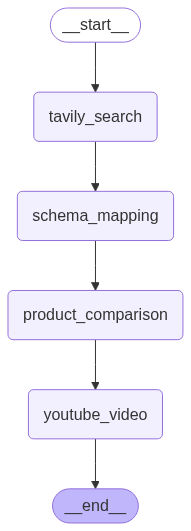

In [12]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
initial_state = {"query": "Best smartphone under 30000 India 2025 for best camera quality" }

for event in graph.stream(input=initial_state,stream_mode="updates"):
    print(event)

Extracted Blogs Content: [{'title': 'Best Phones Under 30000 in India (26th June 2025) | Gadgets 360', 'url': 'https://www.gadgets360.com/mobiles/best-phone-under-30000', 'content': "Best Phones Under 30000 in India (27th June 2025) | Gadgets 360 English Edition हिंदी বাংলা தமிழ் తెలుగు മലയാളം ગુજરાતી मराठी Deutsch Française Home Mobiles Phone Finder Best Mobile Phones Under 30000 In India BEST MOBILE PHONES UNDER 30000 IN INDIA By Gadgets 360 Staff | Prices last updated on 27 June 2025 The prices of flagship-class smartphones have skyrocketed over the past few years, and it isn’t shocking at all to see people spend more than Rs. 70,000 for the latest iPhone, Samsung Galaxy, and Google Pixel models. Thankfully, if your budget isn’t quite so generous, you can get very nearly the same performance, features, and style for less than half as much. The sub-Rs. 30,000 category has plenty of options, and some of the recently launched models at this price level even boast of features that much 

{'comparisons': [{'product_name': 'iQOO Neo 10R',
   'specs_comparison': {'processor': 'Qualcomm Snapdragon 8s Gen 3',
    'battery': '6400mAh',
    'camera': '50MP + 8MP',
    'display': '6.78-inch, 1260x2800 pixels',
    'storage': '128GB'},
   'ratings_comparison': {'overall_rating': None,
    'performance': None,
    'battery_life': None,
    'camera_quality': None,
    'display_quality': None},
   'reviews_summary': 'Features a high refresh rate display with HDR10 support and excellent performance. It has a massive battery and fast charging. However, the design is basic, and imaging is not a strong point, especially in low light.'},
  {'product_name': 'Nothing Phone 3a Pro',
   'specs_comparison': {'processor': 'Qualcomm Snapdragon 7s Gen 3',
    'battery': '5000mAh',
    'camera': '50MP + 50MP + 8MP',
    'display': '6.70-inch, 1080x2392 pixels',
    'storage': '128GB'},
   'ratings_comparison': {'overall_rating': None,
    'performance': None,
    'battery_life': None,
    'came

{'product_comparison': {'comparison': [{'product_name': 'iQOO Neo 10R', 'specs_comparison': {'processor': 'Qualcomm Snapdragon 8s Gen 3', 'battery': '6400mAh', 'camera': '50MP + 8MP', 'display': '6.78-inch, 1260x2800 pixels', 'storage': '128GB'}, 'ratings_comparison': {'overall_rating': None, 'performance': None, 'battery_life': None, 'camera_quality': None, 'display_quality': None}, 'reviews_summary': 'Features a high refresh rate display with HDR10 support and excellent performance. It has a massive battery and fast charging. However, the design is basic, and imaging is not a strong point, especially in low light.'}, {'product_name': 'Nothing Phone 3a Pro', 'specs_comparison': {'processor': 'Qualcomm Snapdragon 7s Gen 3', 'battery': '5000mAh', 'camera': '50MP + 50MP + 8MP', 'display': '6.70-inch, 1080x2392 pixels', 'storage': '128GB'}, 'ratings_comparison': {'overall_rating': None, 'performance': None, 'battery_life': None, 'camera_quality': None, 'display_quality': None}, 'reviews_s